# IceTop Rigidity Analysis

Before running this notebook, please make sure you have the following .npy files in the appropriate folders:

- energy.npy

- Gweights.npy

- Hweights.npy

- reco_pass.npy

- hits.npy

- particle_type.npy

- showerplane_zen.npy

- laputop_zen.npy

If not, please run save_data.py for the year and interaction model you would like to analyze.

**Note:** This file was made with the ability to compare H4a and GSF. By default, only GSF is used. To enable H4a, go to the code Dictionaries set-up block under the Set-up section. Then go to the SIMS dictionary and uncomment the H4a key.

# Table of Contents
##### 1. [Set-up](#set-up)
##### 2. [Rate vs. Energy](#weighted-rate-vs-energy)
##### 3. [Mean Atomic Charge](#mean-atomic-charge)
##### 4. [Fractional Composition vs. Energy](#fractional-compositions-vs-energy)
##### 5. [Table of fractional comp, ln(A), median log(E), and median log(R)](#table-of-fractional-comp-lna-median-loge-and-median-logR)
##### 6. [Rate vs. Rigidity](#weighted-rate-vs-rigidity)
##### 7. [Energy vs. Rigidity](#energy-vs-rigidity)
##### 8. [Dipole Phase and Amplitude](#dipole-phase-and-amplitude)
##### 9. [Dipole Phase and Amplitude vs. Rigidity and Energy; Rigidity vs. Energy](#dipole-phase-and-amplitude-vs-rigidity-and-energy-rigidity-vs-energy)
##### 10. [Dipole Phase and Amplitude vs. Energy](#dipole-phase-and-amplitude-vs-energy)
##### 11. [Dipole Phase and Amplitude vs. Rigidity](#dipole-phase-and-amplitude-vs-rigidity)
##### 12. [Rigidity vs. Energy](#rigidity-vs-energy)

In [125]:
# Control Panel: Set the nbins for each graph, the year and the interaction model you want to analyze, and whether to include an "IceCube Preliminary" message
nbins = 50
includePreliminaryMessage = False
'''
Options:
2012
2015
2018
'''
year = 2012
'''
Options (depending on year): 
EPOS-LHC [2012, 2018]
QGSJET-II-04 [2012, 2018]
SIBYLL2.1 [2012, 2015]
SIBYLL2.3 [2012]
SIBYLL2.3d [2018]
'''
model = 'SIBYLL2.1'

## Set-Up

In [47]:
# Import libraries
import os, getpass

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtran

from pandas import DataFrame

In [3]:
# Load in the SIBYLL2.1 particle sims - note that these will also be your variable names
KEYS = ['energy', 'particle_type', 'hits', 'reco_pass', 'showerplane_zen', 'laputop_zen', 'Hweights', 'Gweights']

for key in KEYS:
    if os.path.isfile(f'/data/user/tfutrell/it_anisotropy/{year}/{model}/{key}.npy'):
        with open(f'/data/user/tfutrell/it_anisotropy/{year}/{model}/{key}.npy', 'rb') as file:
            globals()[key] = np.load(file)
    else:
        print(f'{key}.npy does not exist or is not in the required folder.')

# Load in the in-ice data
d = np.load("/data/user/juancarlos/notebooks/dst_20904_v3.npz")

In [4]:
# Dictionary set-ups
# Set up composition-dependent dictionaries based on year and interaction model (some only have Fe and p)
if year == 2012 and (model == 'EPOS-LHC' or model == 'SIBYLL2.3' or model == 'QGSJET-II-04'):
    # Cuts for different compositions
    COMPS = {
        'proton': particle_type == 2.21200000e+03,
        'iron': particle_type == 1.00026056e+09,
        'true': np.tile(True, len(energy))
    }

    # Graph colors by composition
    COLORS = {
        'true' : 'black',
        'proton': 'red',
        'iron': 'blue'
    }

    # Graph labels by composition
    LABEL = {
        'true' : 'Data',
        'proton': 'p',
        'iron': 'Fe'
    }
else:
    # Cuts for different compositions
    COMPS = {
        'proton': particle_type == 2.21200000e+03,
        'helium' : particle_type == 1.00002004e+09,
        'oxygen': particle_type == 1.00008016e+09,
        'iron': particle_type == 1.00026056e+09,
        'true': np.tile(True, len(energy))
    }

    # Graph colors by composition
    COLORS = {
        'true' : 'black',
        'proton': 'red',
        'helium': 'orange',
        'oxygen': 'purple',
        'iron': 'blue'
    }

    # Graph labels by composition
    LABEL = {
        'true' : 'Data',
        'proton': 'p',
        'helium': 'He',
        'oxygen': 'O',
        'iron': 'Fe'
    }

# amu of different compositions
A = {
    'proton': 1.0073,
    'helium': 4.0026,
    'oxygen': 16,
    'iron': 55.845  
}

# Number of protons for different compositions
Z = {
    'proton': 1,
    'helium': 2,
    'nitrogen': 7,
    'oxygen': 8,
    'aluminum': 13,
    'iron': 26
}

# IceTop Tiers and quality cuts - quality cuts may not work well with some years and Tiers (e.g. reco_succeeded cancels out Tier 4 for 2012)
tier1_quality_cuts = (showerplane_zen < np.radians(55)) * (reco_pass == 1)
quality_cuts = (laputop_zen < np.radians(55)) * (reco_pass == 1)
# Calculation for the Tier offset per year
offset = round((year - 2011)/2)

if year < 2015:
    TIERS = {
        'Tier 1': (3 <= hits) * (hits < 5),
        'Tier 2': (5 <= hits) * (hits < 10 - offset) * quality_cuts,
        'Tier 3': (10 - offset <= hits) * (hits < 14 - offset) * quality_cuts,
        'Tier 4': (14 - offset <= hits) * quality_cuts
    }
    # Include Tier 1 quality cuts with year-dependent exceptions
    if year == 2012:
        TIERS['Tier 1'] *= (showerplane_zen < np.radians(55))
    else:
        TIERS['Tier 1'] *= tier1_quality_cuts

else:
    TIERS = {
        'Tier 3': (10 - offset <= hits) * (hits < 14 - offset),
        'Tier 4': (14 - offset <= hits) * quality_cuts
    }
    # Include default quality cuts with year-dependent exceptions
    if year == 2015:
        TIERS['Tier 3'] = (laputop_zen < np.radians(55))
    else:
        TIERS['Tier 3'] *= quality_cuts

# Weights
SIMS = {
     'H4a': Hweights,
    'GSF': Gweights
}

# Flux from histogram
FLUX = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}

# Histogram bins
HBINS = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}

# Linestyle by weights
LINESTYLE = {
    'H4a': '--',
    'GSF': None
}

# Dictionary for total flux times log(Z) and for total flux across compositions for each Tier and weight.
TOTALS = {
    'numerator'  : {'Tier 1': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 2': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 3': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 4': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)}},
    'denominator': {'Tier 1': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 2': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 3': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 4': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)}}
}

# Table for partial compositions, ln(A), median log of rigidity and energy for each Tier and weight
if year < 2015:
    TABLE = {
        'H4a': {'Tier 1': {},
                'Tier 2': {},
                'Tier 3': {},
                'Tier 4': {}},
        'GSF': {'Tier 1': {},
                'Tier 2': {},
                'Tier 3': {},
                'Tier 4': {}}
    }
else:
    TABLE = {
        'H4a': {'Tier 3': {},
                'Tier 4': {}},
        'GSF': {'Tier 3': {},
                'Tier 4': {}}
    }

IC_COMPS = {
    'proton': d['type'] == 2212,
    'helium': d['type'] == 1.00002004e+09,
    'nitrogen': d['type'] == 1.000070140e+09,
    'aluminum': d['type'] == 1.00013027e+09,
    'iron': d['type'] == 1.00026056e+09
}

# To avoid linestyle errors in dipole phase and amplitude graphs
FMT = {
    'H4a': '--o',
    'GSF': '-o'
}

In [5]:
# Define a function for weighted medians, or weighted quantiles
def weighted_quantiles(values, weights, quantiles=0.5):
    if len(values) == 0:
        return 0
    else:
        i = np.argsort(values)
        c = np.cumsum(weights[i])
        return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [6]:
# Calculate log10(rigidity)
# The -3 is to scale energy to TeV
rigidity = np.log10(energy) - 3

for comp, comp_cut in COMPS.items():
    if not comp == 'true':
        rigidity[comp_cut] -= np.log10(Z[comp])

## Weighted rate vs. energy

Tier 1
--------------------------
H4a
    proton
        Median: 0.26 TeV
        68%: 0.14-0.52 TeV

    iron
        Median: 0.46 TeV
        68%: 0.22-0.94 TeV

    true
        Median: 0.3 TeV
        68%: 0.15-0.62 TeV

GSF
    proton
        Median: 0.27 TeV
        68%: 0.14-0.52 TeV

    iron
        Median: 0.39 TeV
        68%: 0.2-0.94 TeV

    true
        Median: 0.3 TeV
        68%: 0.15-0.62 TeV

Tier 2
--------------------------
H4a
    proton
        Median: 0.79 TeV
        68%: 0.37-1.61 TeV

    iron
        Median: 1.39 TeV
        68%: 0.71-3.06 TeV

    true
        Median: 0.95 TeV
        68%: 0.45-2.03 TeV

GSF
    proton
        Median: 0.84 TeV
        68%: 0.4-1.61 TeV

    iron
        Median: 1.2 TeV
        68%: 0.62-3.06 TeV

    true
        Median: 0.94 TeV
        68%: 0.45-2.03 TeV

Tier 3
--------------------------
H4a
    proton
        Median: 2.04 TeV
        68%: 1.25-3.77 TeV

    iron
        Median: 3.23 TeV
        68%: 1.88-6.98 TeV

    t

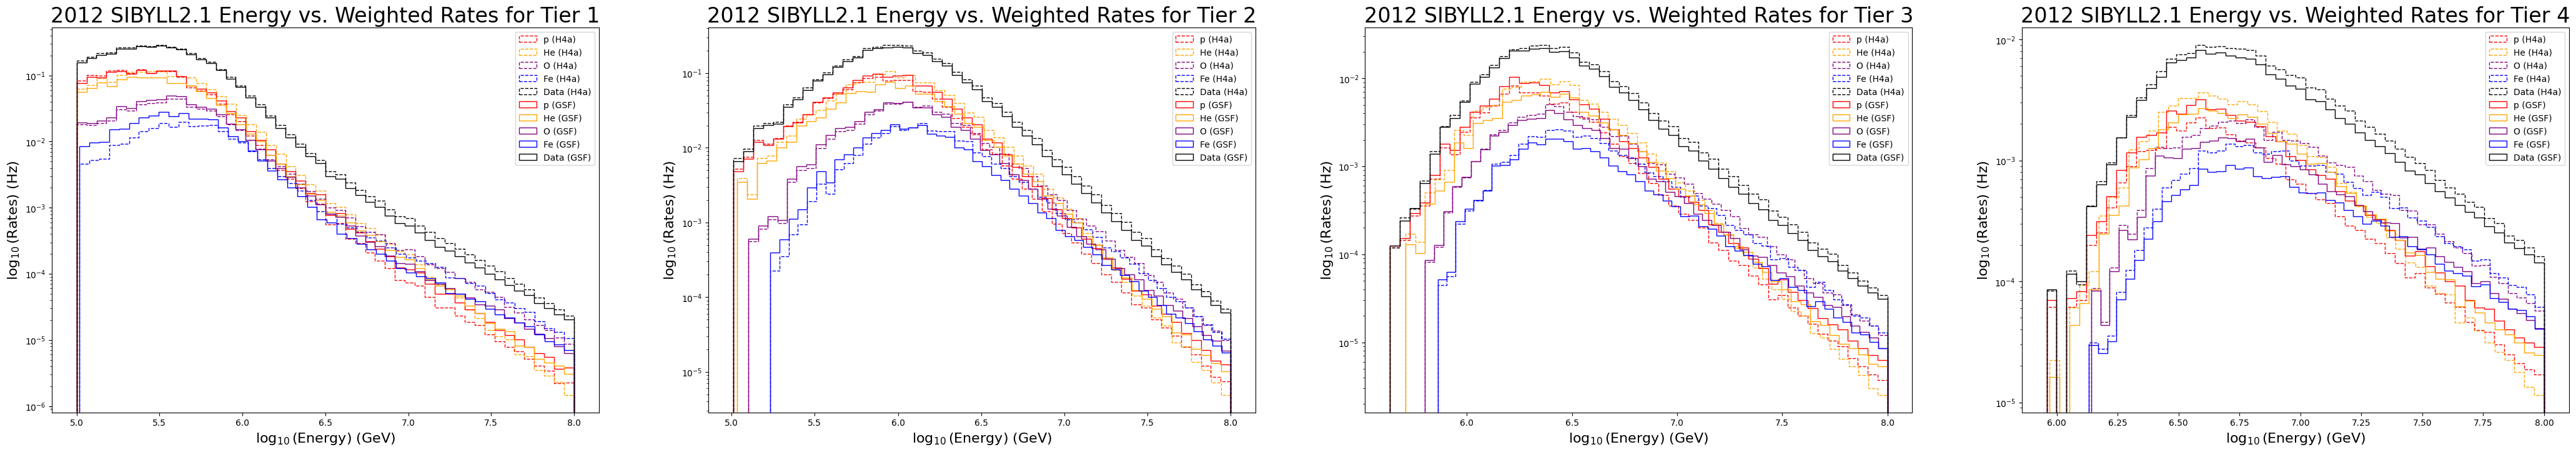

In [7]:
# Prepare the graphs
ncols = len(TIERS)
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    # Print Tier for table
    print(tier)
    print('--------------------------')
    
    for weight_name, weights in SIMS.items():
        # Print weights for table
        print(weight_name)

        for comp, comp_cut in COMPS.items():
            # Combine cuts
            combined_cut = comp_cut * tier_cut

            # Set up the histogram arguments
            hist_args = {
                'bins': nbins,
                'linestyle': LINESTYLE[weight_name],
                'log': True,
                'label': f'{LABEL[comp]} ({weight_name})',
                'histtype':'step',
                'color': COLORS[comp]
            }

            # Graph primary energy
            FLUX[comp][tier][weight_name], HBINS[comp][tier][weight_name], patches1 = ax.hist(np.log10(energy[combined_cut]), weights=weights[combined_cut], **hist_args)

            # Print median energy and its first sigma
            if comp == 'proton' or comp == 'iron' or comp == 'true':
                print(f'    {comp}')
                print(f'        Median: {round(weighted_quantiles(energy[combined_cut] / 1e6, weights[combined_cut]), 2)} TeV')
                print(f'        68%: {round(weighted_quantiles(energy[combined_cut] / 1e6, weights[combined_cut], quantiles=.16), 2)}-{round(weighted_quantiles(energy[combined_cut] / 1e6, Hweights[combined_cut], .84), 2)} TeV')
                print()

    # Label axes and add legend and title
    ax.set_xlabel('$\log_{{10}}$(Energy) (GeV)', size=16)
    ax.set_ylabel('$\log_{{10}}$(Rates) (Hz)', size=16)
    ax.set_title(f'{year} {model} Energy vs. Weighted Rates for {tier}', size=24)
    ax.legend()

## Mean Atomic Charge

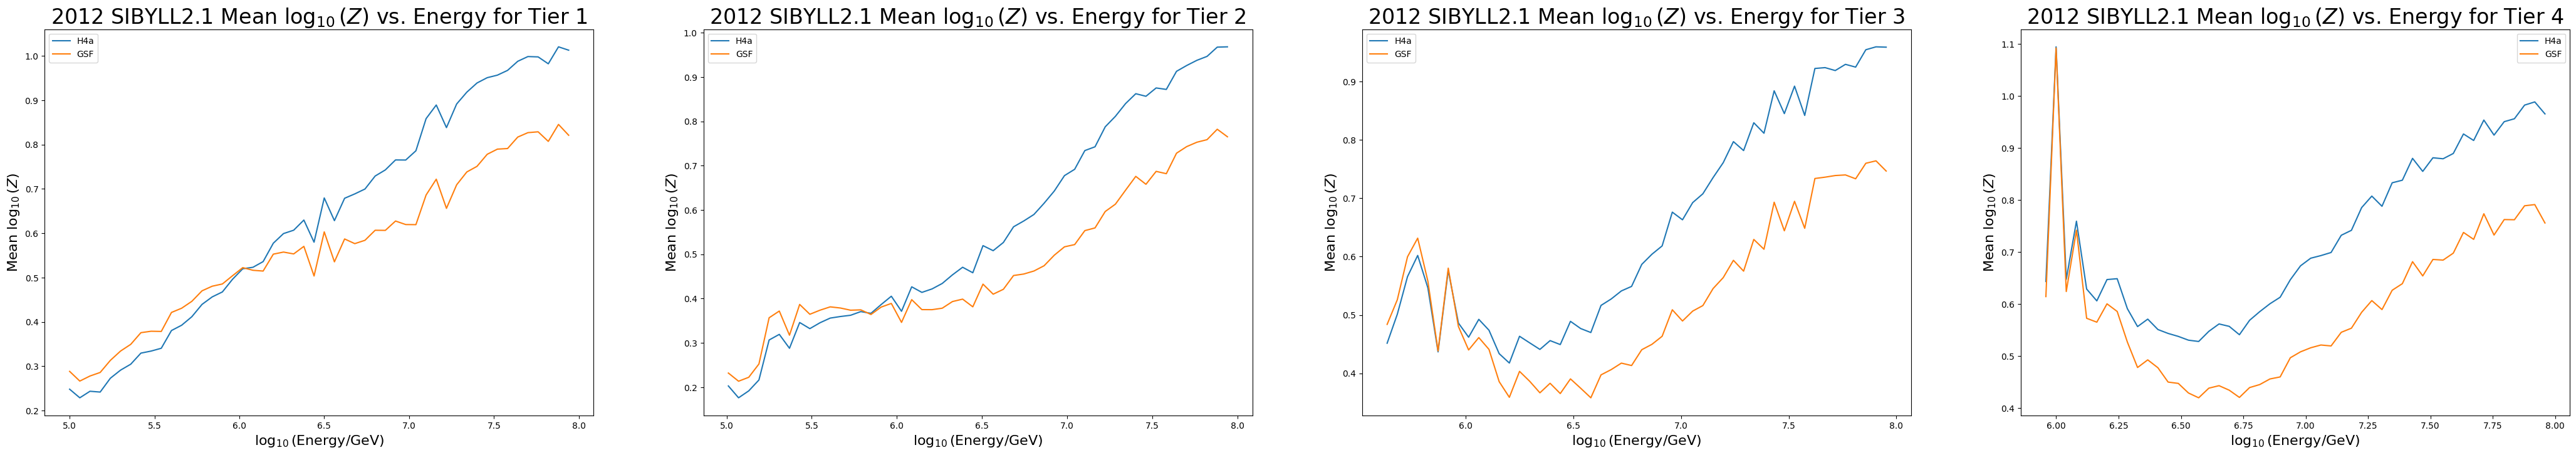

In [8]:
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, ax in zip(TIERS, axs):    
    for weight_name in SIMS:
        for comp in COMPS:
            if not comp == 'true':
                # Sum flux times the number of protons for each comp, Tier and weight
                TOTALS['numerator'][tier][weight_name] += FLUX[comp][tier][weight_name] * np.log10(Z[comp])

                # Sum flux for each comp, Tier and weight
                TOTALS['denominator'][tier][weight_name] += FLUX[comp][tier][weight_name]

        # Calculate <Z>
        meanZ = TOTALS['numerator'][tier][weight_name] / TOTALS['denominator'][tier][weight_name]

        # Plot <Z> vs. energy
        ax.plot(HBINS['true'][tier][weight_name][:-1], meanZ, label=weight_name)

    ax.set_xlabel('$\log_{{10}}$(Energy/GeV)', size=16)
    ax.set_ylabel('Mean $\log_{{10}}(Z)$', size=16)
    ax.set_title(f'{year} {model} Mean $\log_{{10}}(Z)$ vs. Energy for {tier}', size=24)

    ax.legend()

## Fractional Compositions vs. Energy

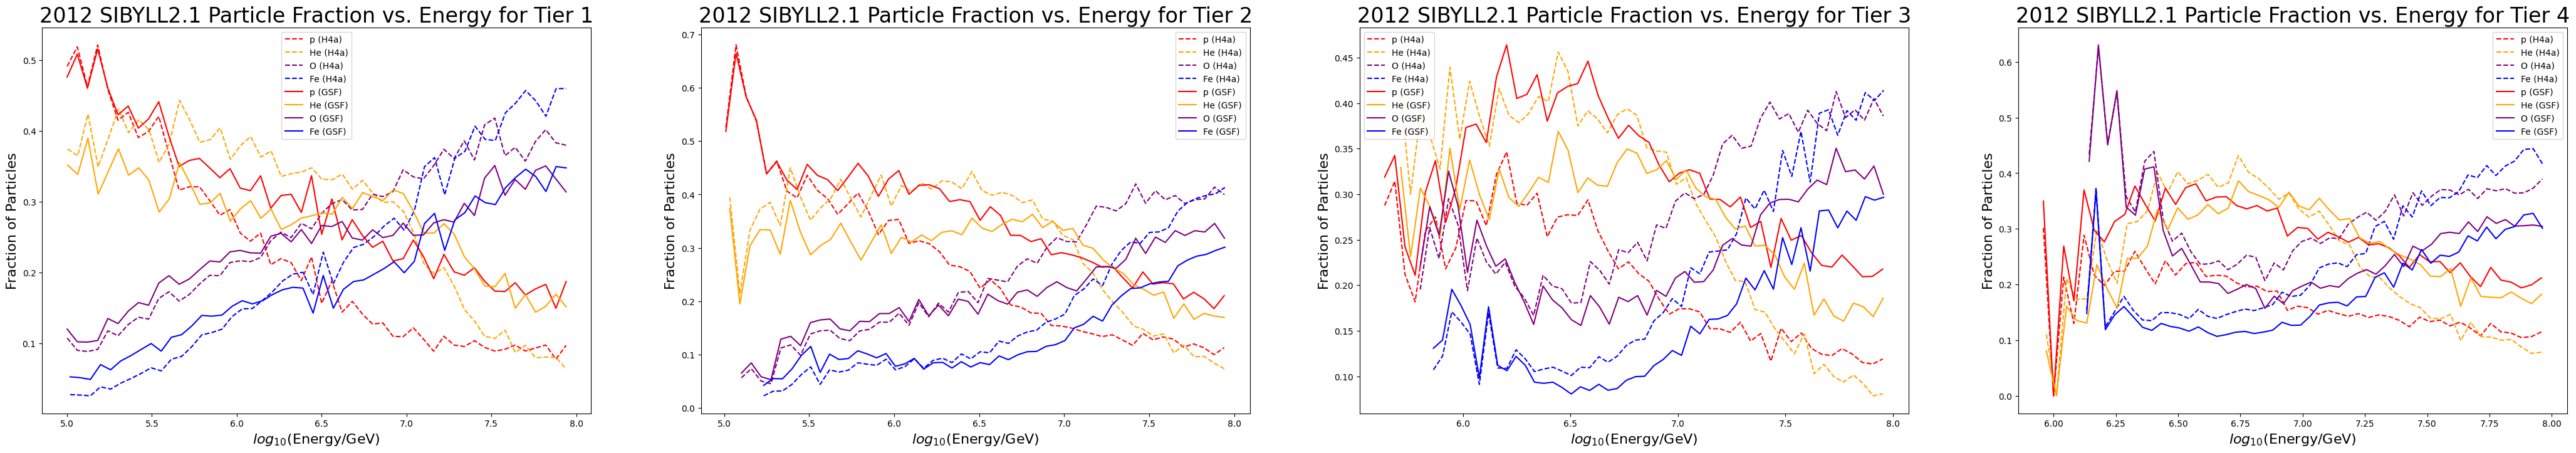

In [9]:
# Particle Fraction vs. Energy
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, ax in zip(TIERS, axs):
    for weight_name in SIMS:
        for comp in COMPS:
            # Plot fractional composition
            if not comp == 'true':
                ax.plot(HBINS[comp][tier][weight_name][:-1], FLUX[comp][tier][weight_name] / TOTALS['denominator'][tier][weight_name],
                label=f'{LABEL[comp]} ({weight_name})', linestyle=LINESTYLE[weight_name], color=COLORS[comp])

    ax.set_xlabel('$log_{{10}}$(Energy/GeV)', size=16)
    ax.set_ylabel('Fraction of Particles', size=16)
    ax.set_title(f'{year} {model} Particle Fraction vs. Energy for {tier}', size=24)

    ax.legend()

# Table of fractional comp, ln(A), median log(E), and median log(R)

In [10]:
print(f'{year} {model}')
print()

for weight_name, weights in SIMS.items():
    # Print weight name for data table
    print(weight_name)
    print()

    for tier, tier_cut in TIERS.items():
        # Start ln_A at zero
        ln_A = 0

        for comp, comp_cut in COMPS.items():
            if not comp == 'true':
                # Save the partial compositions to the table
                TABLE[weight_name][tier][f'{comp} part'] = round(np.mean(FLUX[comp][tier][weight_name]) / np.mean(TOTALS['denominator'][tier][weight_name]), 3)

                # Calculate ln(A) with partial compositions
                ln_A += TABLE[weight_name][tier][f'{comp} part'] * np.log(A[comp])

        # Save ln(A) to the table
        TABLE[weight_name][tier]['ln(A)'] = round(ln_A, 3)
        
        # Calculate median log E (Scaled to TeV) and rigidity
        TABLE[weight_name][tier]['median(log(E))'] = round(weighted_quantiles(np.log10(energy)[tier_cut] - 3, weights=weights[tier_cut]), 3)
        TABLE[weight_name][tier]['median(log(R))'] = round(weighted_quantiles(rigidity[tier_cut], weights=weights[tier_cut]), 3)
        median_R = TABLE[weight_name][tier]['median(log(R))']

    # Print out the table for that weight
    print(DataFrame(TABLE[weight_name]))
    print()

2012 SIBYLL2.1

H4a

                Tier 1  Tier 2  Tier 3  Tier 4
proton part      0.399   0.348   0.275   0.201
helium part      0.393   0.400   0.390   0.346
oxygen part      0.142   0.166   0.212   0.272
iron part        0.066   0.086   0.123   0.181
ln(A)            1.207   1.364   1.625   1.964
median(log(E))   2.474   2.976   3.390   3.737
median(log(R))   2.204   2.649   3.027   3.242

GSF

                Tier 1  Tier 2  Tier 3  Tier 4
proton part      0.417   0.422   0.393   0.332
helium part      0.330   0.318   0.314   0.314
oxygen part      0.160   0.171   0.191   0.219
iron part        0.093   0.089   0.102   0.135
ln(A)            1.278   1.276   1.378   1.588
median(log(E))   2.474   2.971   3.381   3.718
median(log(R))   2.186   2.668   3.095   3.361



## Weighted rate vs rigidity

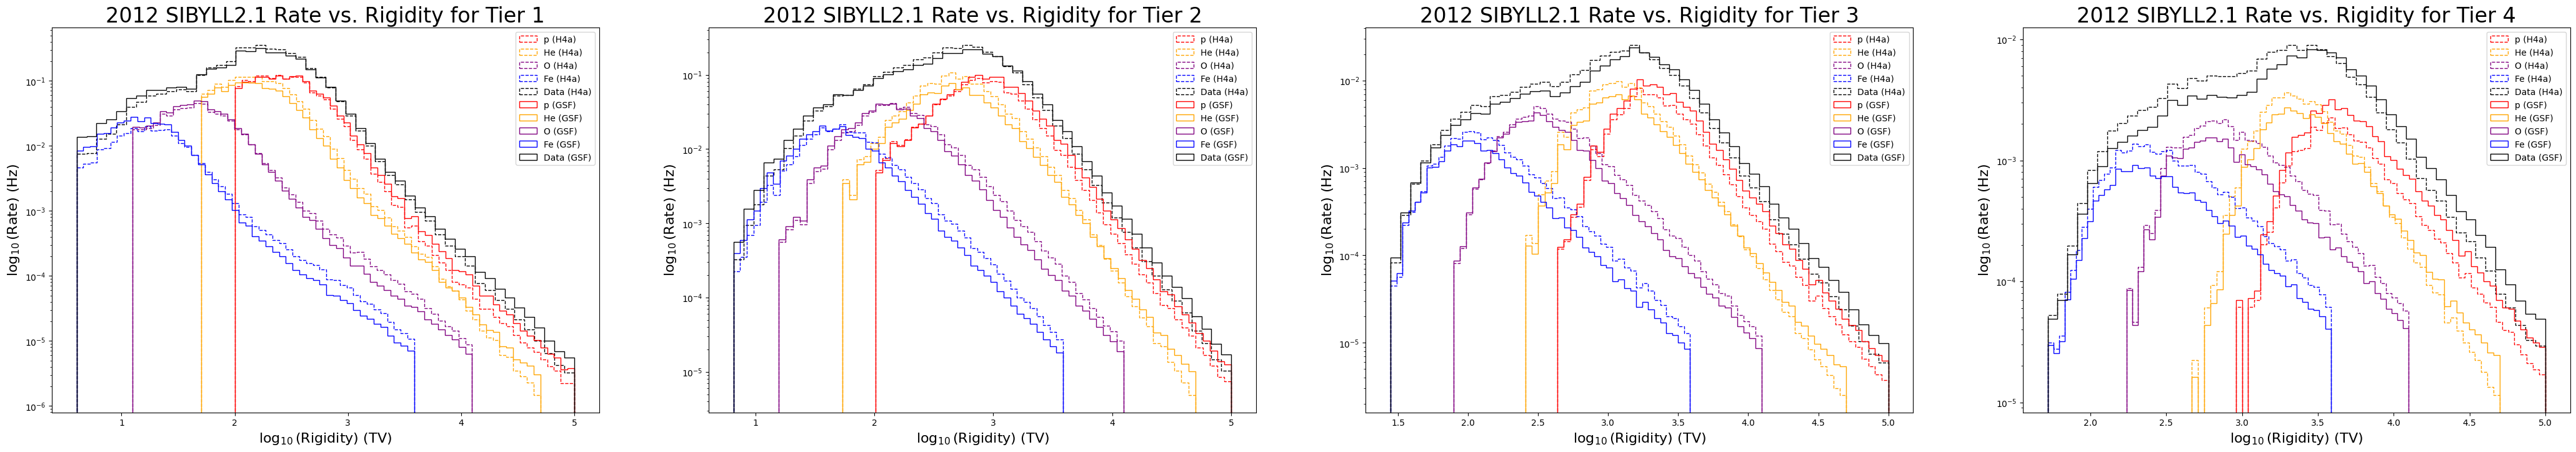

In [11]:
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    for weight_name, weights in SIMS.items():
        for comp, comp_cut in COMPS.items():
            # Set up the histogram arguments
            hist_args = {
                'bins': nbins,
                'linestyle': LINESTYLE[weight_name],
                'log': True,
                'label': f'{LABEL[comp]} ({weight_name})',
                'histtype':'step',
                'color': COLORS[comp]
            }

            # Graph rate vs. rigidity
            combined_cut = tier_cut * comp_cut
            ax.hist(rigidity[combined_cut], weights=weights[combined_cut], **hist_args)
            #ax.scatter(weighted_quantiles(rigidity[combined_cut], weights=weights[combined_cut]), np.median(rate[0]), label=f'Median {comp} ({weight_name})', c=COLORS[comp])

    ax.set_xlabel('$\log_{{10}}$(Rigidity) (TV)', size=16)
    ax.set_ylabel('$\log_{{10}}$(Rate) (Hz)', size=16)
    ax.set_title(f'{year} {model} Rate vs. Rigidity for {tier}', size=24)
    ax.legend()

## Energy vs. rigidity

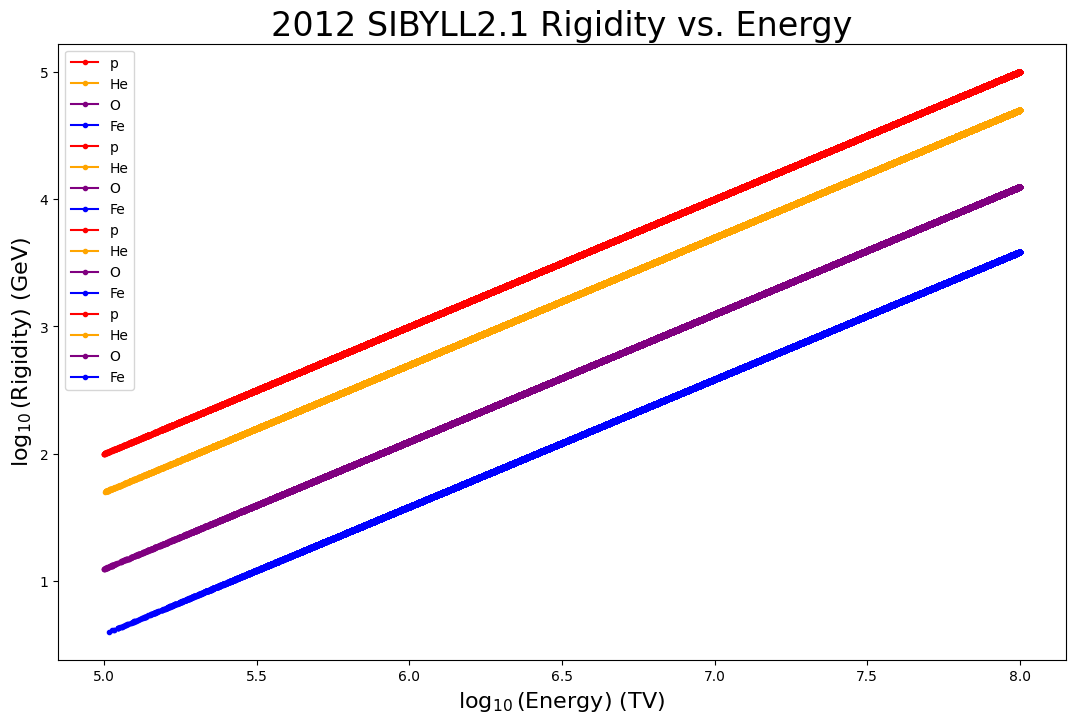

In [12]:
fig, axs = plt.subplots(figsize=(13, 8))

for tier_cut in TIERS.values():
    for comp, comp_cut in COMPS.items():
        if not comp == 'true':
            combined_cut = comp_cut * tier_cut
            # Graph energy vs. rigidity
            axs.plot(np.log10(energy[combined_cut]), rigidity[combined_cut], '.-', label=LABEL[comp], color=COLORS[comp])
    
    axs.set_xlabel('$\log_{{10}}$(Energy) (TV)', size=16)
    axs.set_ylabel('$\log_{{10}}$(Rigidity) (GeV)', size=16)
    axs.set_title(f'{year} {model} Rigidity vs. Energy', size=24)

    axs.legend()
plt.show()

# Dipole Phase and Amplitude vs. Energy and Rigidity; Rigidity vs. Energy

## Set-Up

In [13]:
# IceTop amplitude, phase, and associated errors
if year < 2015:
    it_amplitude = 1.74 * np.array([4.9, 13.5, 11.9, 12.5])
    it_phase = [-96.1, -93.8, -72.2, -64.1]

    it_amplitude_error = [1.1, 1.2, 1.7, 4.2]
    it_phase_err = [12.6, 5.0, 7.4, 16.1]
else:
    it_amplitude = 1.74 * np.array([11.9, 12.5])
    it_phase = [-72.2, -64.1]

    it_amplitude_error = [1.7, 4.2]
    it_phase_err = [7.4, 16.1]

# In-ice amplitude (with upper limit), phase, and associated errors
ic_amplitude = [13.33, 11.24, 8.28, 4.81, 2.04, 3.6, 7.2, 14.0, 18.0]
ic_upper_limit = [13.33, 11.24, 8.28, 4.81, 2.04, 3.6, 7.2, 14.0, 33.4]
ic_phase = [52.76, 50.91, 49.2, 41.05, 18.0, -71.0, -86.0, -85.0, -107.0]

ic_amplitude_error = [0.05, 0.05, 0.09, 0.17, 0.33, 0.5, 0.8, 2.4, 7]
ic_phase_err = [0.20, 0.28, 0.6, 2.0, 9, 9, 6, 10, 22]

# Calculate in-ice rigidity
ic_rigidity = np.log10(d['mc_energy']) - 3
for comp, comp_cut in IC_COMPS.items():
    ic_rigidity[comp_cut] -= np.log10(Z[comp])

# Set up in-ice BINS
BINS={
'4.125': (d['reco_energy'] > 4) * (d['reco_energy'] < 4.25),
'4.375': (d['reco_energy'] > 4.25) * (d['reco_energy'] < 4.5),
'4.625': (d['reco_energy'] > 4.5) * (d['reco_energy'] < 4.75),
'4.875': (d['reco_energy'] > 4.75) * (d['reco_energy'] < 5),
'5.125': (d['reco_energy'] > 5) * (d['reco_energy'] < 5.25),
'5.375': (d['reco_energy'] > 5.25) * (d['reco_energy'] < 5.5),
'5.75': (d['reco_energy'] > 5.5) * (d['reco_energy'] < 6),
'6.25': (d['reco_energy'] > 6) * (d['reco_energy'] < 6.5), 
'7.25': (d['reco_energy'] > 6.5) * (d['reco_energy'] < 8)
}

# In-ice quality cuts
qual_cut = (d['zenith'] > 0.002) * (d['zenith'] < (np.pi - 0.002)) * (d['nchannel'] >= 10) * (d['mc_energy'] == d['mc_energy']) * (d['rlogl'] < 25)

lParams = {'size':'xx-large','color':'black','family':'sans-serif'}

## Dipole phase and amplitude vs. energy

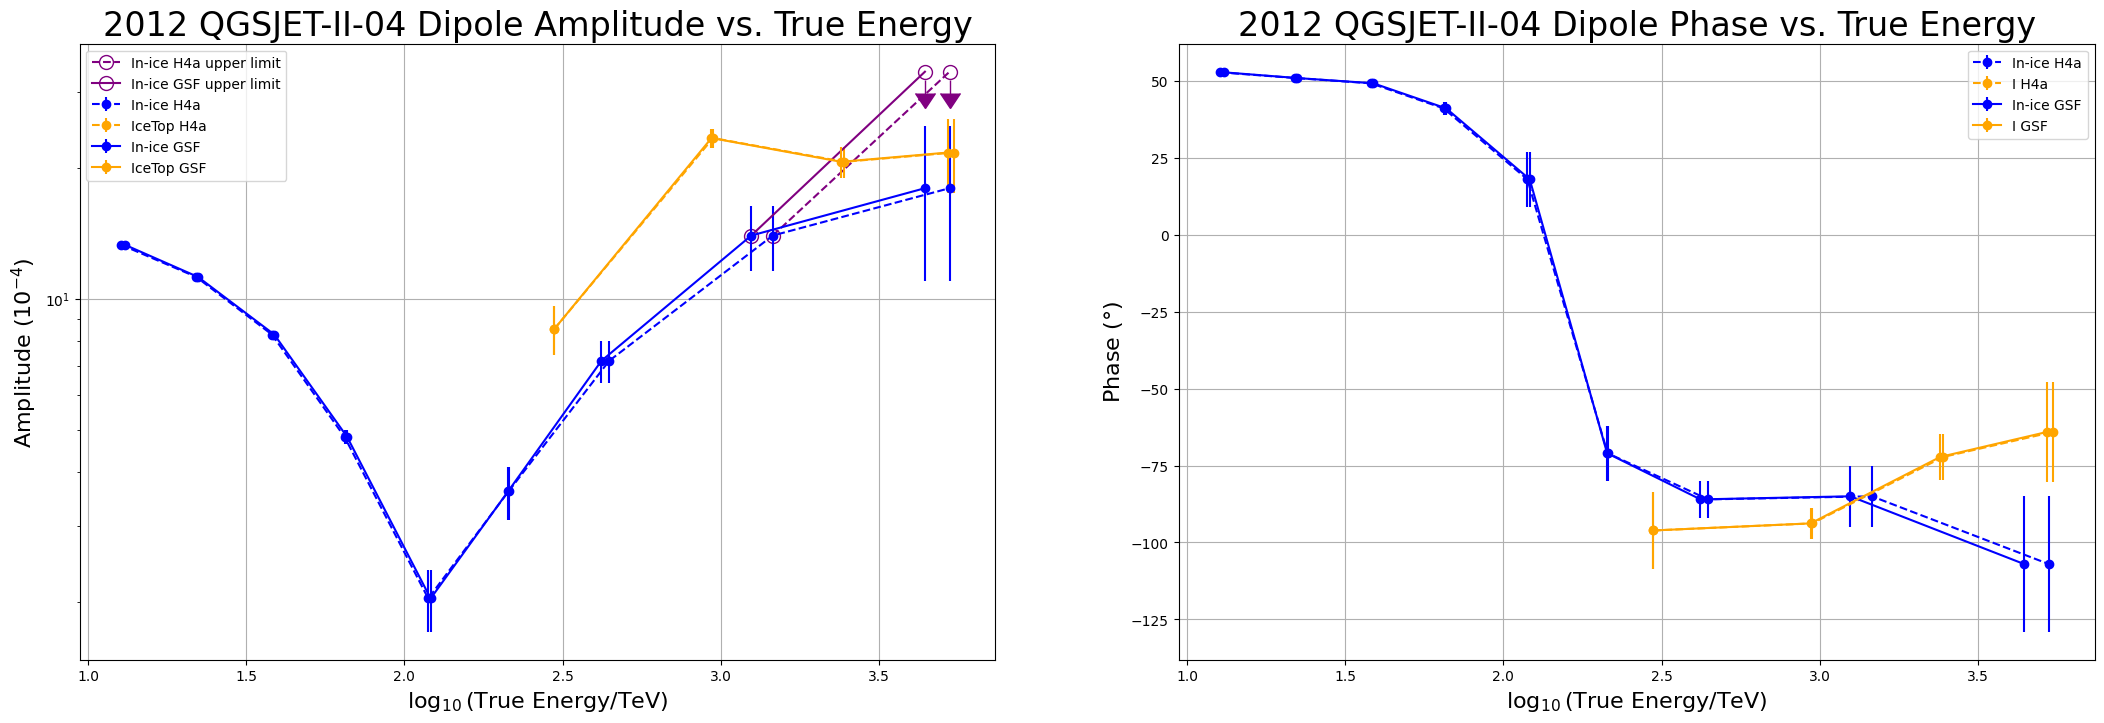

In [123]:
fig, axs = plt.subplots(figsize=(26, 8), ncols=2)

for weight_name, weights in SIMS.items():
    # Calculate median rigidity and energy - note BINS are the in-ice BINS and comes from reco_energy.ipynb
    if weight_name == 'H4a':
        ic_weights = d['GaisserH4a']
    else:
        ic_weights = d['GlobalSplineFit5Comp']

    ic_median_rigidity = [weighted_quantiles(ic_rigidity[energy_bin * qual_cut], weights=ic_weights[energy_bin * qual_cut]) for energy_bin in BINS.values()]
    it_median_rigidity = [TABLE[weight_name][tier]['median(log(R))'] for tier in TABLE[weight_name]]

    ic_median_energy = [weighted_quantiles(np.log10(d['mc_energy'][energy_bin * qual_cut]) - 3, weights=ic_weights[energy_bin * qual_cut]) for energy_bin in BINS.values()]
    it_median_energy = [weighted_quantiles(np.log10(energy[tier]) - 3, weights=weights[tier]) for tier in TIERS.values()]

    # Plot amplitude vs. energy
    axs[0].set_yscale("log", nonpositive='mask')
    axs[0].plot(ic_median_energy[-1:], ic_upper_limit[-2:], label=f'In-ice {weight_name} upper limit', c='purple', linestyle = '--' if weight_name=='H4a' else '-', marker = 'o', markerfacecolor='none', ms='10')    
    axs[0].plot(ic_median_energy[-2:][1], ic_upper_limit[-2:][1]-1.5, c='purple', linestyle='', marker = 3, ms = '16')
    axs[0].plot(ic_median_energy[-2:][1], ic_upper_limit[-2:][1]-3.5, c='purple', linestyle='', marker = 11, ms = '14')
    axs[0].errorbar(ic_median_energy, ic_amplitude, yerr=ic_amplitude_error, label=f'In-ice {weight_name}', c='blue', fmt=FMT[weight_name])
    axs[0].errorbar(it_median_energy, it_amplitude, yerr=it_amplitude_error, label=f'IceTop {weight_name}', c='orange', fmt=FMT[weight_name])

    axs[0].set_xlabel('$\log_{{10}}$(True Energy/TeV)', size=16)
    axs[0].set_ylabel('Amplitude ($10^{{-4}}$)', size=16)
    axs[0].set_title(f'{year} {model} Dipole Amplitude vs. True Energy', size=24)
    if includePreliminaryMessage:
        axs[0].annotate('IceCube Preliminary', xy=(3.0, 5), **lParams)
    
    axs[0].grid(visible=True)
    axs[0].legend()

    # Plot phase vs. energy
    axs[1].errorbar(ic_median_energy, ic_phase, yerr=ic_phase_err, label=f'In-ice {weight_name}', c='blue', fmt=FMT[weight_name])
    axs[1].errorbar(it_median_energy, it_phase, yerr=it_phase_err, label=f'I {weight_name}', c='orange', fmt=FMT[weight_name])

    axs[1].set_xlabel('$\log_{{10}}$(True Energy/TeV)', size=16)
    axs[1].set_ylabel('Phase ($\degree$)', size=16)
    axs[1].set_title(f'{year} {model} Dipole Phase vs. True Energy', size=24)
    if includePreliminaryMessage:
        axs[1].annotate('IceCube Preliminary', xy=(1.25, -65), **lParams)

    axs[1].grid(visible=True)
    axs[1].legend()
    
plt.show()

## Dipole phase and amplitude vs. rigidity

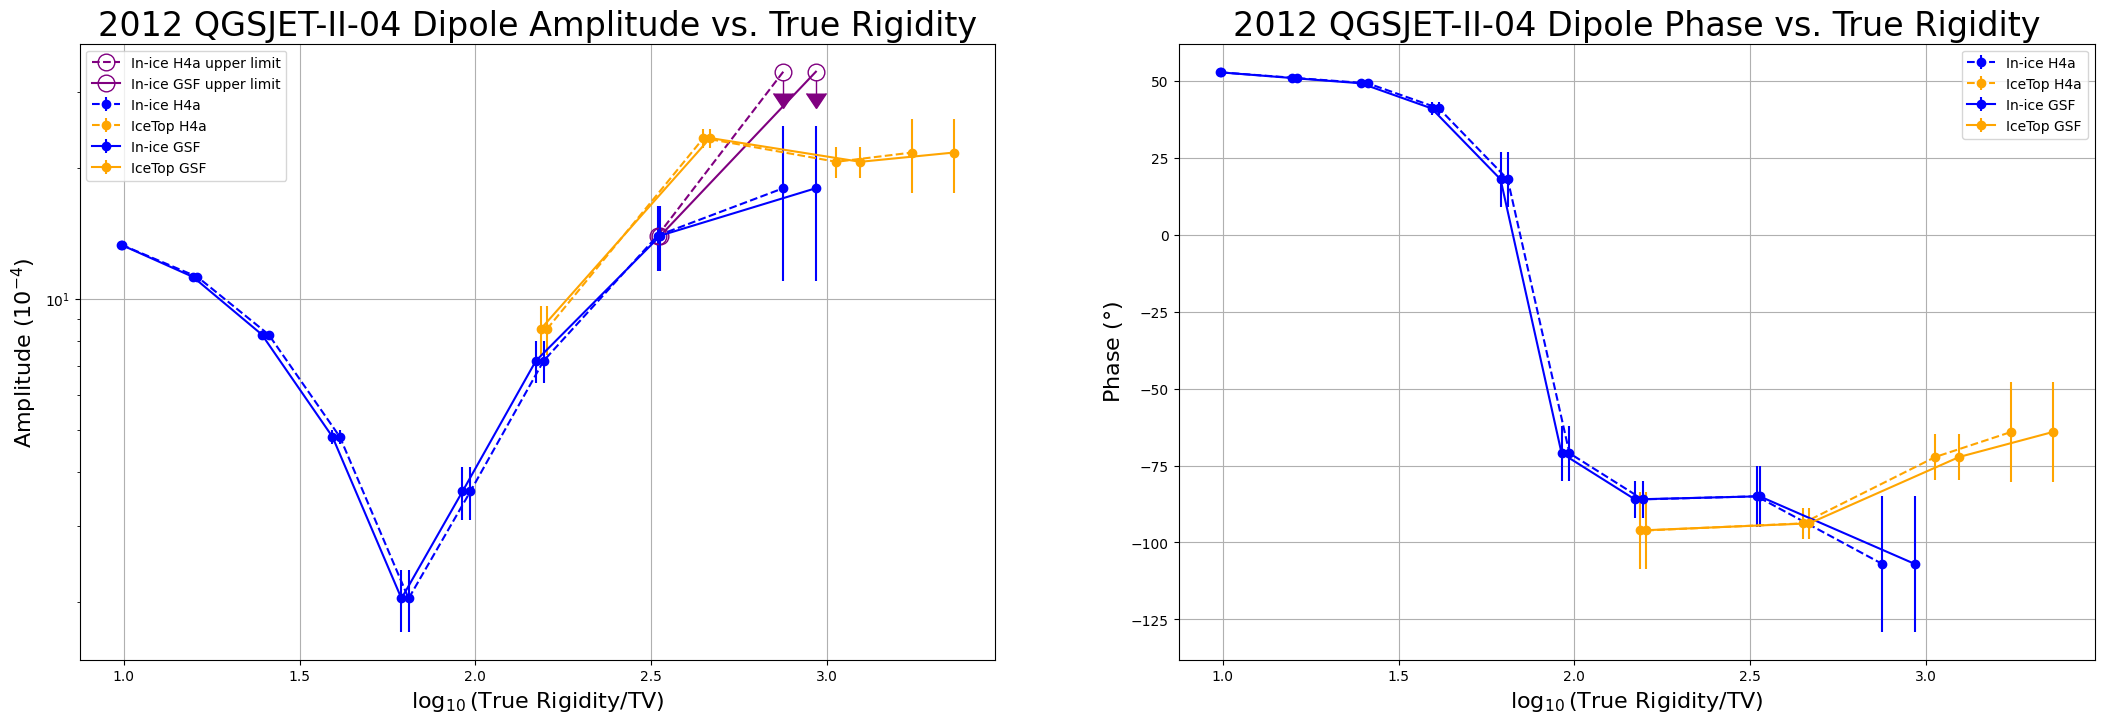

In [124]:
fig, axs = plt.subplots(figsize=(26, 8), ncols=2)

for weight_name, weights in SIMS.items():
    # Calculate median rigidity and energy - note BINS are the in-ice BINS and comes from reco_energy.ipynb
    if weight_name == 'H4a':
        ic_weights = d['GaisserH4a']
    else:
        ic_weights = d['GlobalSplineFit5Comp']

    ic_median_rigidity = [weighted_quantiles(ic_rigidity[energy_bin * qual_cut], weights=ic_weights[energy_bin * qual_cut]) for energy_bin in BINS.values()]
    it_median_rigidity = [TABLE[weight_name][tier]['median(log(R))'] for tier in TABLE[weight_name]]

    ic_median_energy = [weighted_quantiles(np.log10(d['mc_energy'][energy_bin * qual_cut]) - 3, weights=ic_weights[energy_bin * qual_cut]) for energy_bin in BINS.values()]
    it_median_energy = [weighted_quantiles(np.log10(energy[tier]) - 3, weights=weights[tier]) for tier in TIERS.values()]

    # Plot amplitude vs. rigidity
    axs[0].set_yscale("log", nonpositive='mask')

    axs[0].plot(ic_median_rigidity[-2:], ic_upper_limit[-2:], label=f'In-ice {weight_name} upper limit', c='purple',  linestyle = '--' if weight_name=='H4a' else '-', marker = 'o', markerfacecolor='none', ms='12')    
    axs[0].plot(ic_median_rigidity[-2:][k], ic_upper_limit[-2:][1]-1.5, c='purple', linestyle='', marker = 3, ms = '16')
    axs[0].plot(ic_median_rigidity[-2:][k], ic_upper_limit[-2:][1]-3.5, c='purple', linestyle='', marker = 11, ms = '14')
    axs[0].errorbar(ic_median_rigidity, ic_amplitude, yerr=ic_amplitude_error, label=f'In-ice {weight_name}', c='blue', fmt=FMT[weight_name])
    axs[0].errorbar(it_median_rigidity, it_amplitude, yerr=it_amplitude_error, label=f'IceTop {weight_name}', c='orange', fmt=FMT[weight_name])

    # Plot phase vs. rigidity
    axs[1].errorbar(ic_median_rigidity, ic_phase, yerr=ic_phase_err, label=f'In-ice {weight_name}', c='blue', fmt=FMT[weight_name])
    axs[1].errorbar(it_median_rigidity, it_phase, yerr=it_phase_err, label=f'IceTop {weight_name}', c='orange', fmt=FMT[weight_name])
    
axs[0].set_xlabel('$\log_{{10}}$(True Rigidity/TV)', size=16)
axs[0].set_ylabel('Amplitude ($10^{{-4}}$)', size=16)
axs[0].set_title(f'{year} {model} Dipole Amplitude vs. True Rigidity', size=24)
if includePreliminaryMessage:
    axs[0].annotate('IceCube Preliminary', xy=(2.5, 5), **lParams)

axs[0].grid(visible=True)
axs[0].legend()

axs[1].set_xlabel('$\log_{{10}}$(True Rigidity/TV)', size=16)
axs[1].set_ylabel('Phase ($\degree$)', size=16)
axs[1].set_title(f'{year} {model} Dipole Phase vs. True Rigidity', size=24)
if includePreliminaryMessage:
    axs[1].annotate('IceCube Preliminary', xy=(1.15,-65), **lParams)
 
axs[1].grid(visible=True)
axs[1].legend()
    
plt.show()

## Rigidity vs. energy

In [ ]:
fig, axs = plt.subplots(figsize=(13, 8))

for weight_name, weights in SIMS.items():
    if weight_name == 'H4a':
        ic_weights = d['GaisserH4a']
    else:
        ic_weights = d['GlobalSplineFit5Comp']

    ic_median_rigidity = [weighted_quantiles(ic_rigidity[energy_bin * qual_cut], weights=ic_weights[energy_bin * qual_cut]) for energy_bin in BINS.values()]
    it_median_rigidity = [TABLE[weight_name][tier]['median(log(R))'] for tier in TABLE[weight_name]]

    ic_median_energy = [weighted_quantiles(np.log10(d['mc_energy'][energy_bin * qual_cut]) - 3, weights=ic_weights[energy_bin * qual_cut]) for energy_bin in BINS.values()]
    it_median_energy = [weighted_quantiles(np.log10(energy[tier]) - 3, weights=weights[tier]) for tier in TIERS.values()]
    
    # Plot energy vs. rigidty
    ic_energy_err = ([weighted_quantiles(np.log10(d['mc_energy'][energy_bin * qual_cut]), ic_weights[energy_bin * qual_cut]) - weighted_quantiles(np.log10(d['mc_energy'][energy_bin * qual_cut]), ic_weights[energy_bin * qual_cut], quantiles=.16) for energy_bin in BINS.values()], [weighted_quantiles(np.log10(d['mc_energy'][energy_bin * qual_cut]), ic_weights[energy_bin * qual_cut], quantiles=.84) - weighted_quantiles(np.log10(d['mc_energy'][energy_bin * qual_cut]), ic_weights[energy_bin * qual_cut])for energy_bin in BINS.values()])
    ic_rigidity_err = ([weighted_quantiles(ic_rigidity[energy_bin * qual_cut], ic_weights[energy_bin * qual_cut]) - weighted_quantiles(ic_rigidity[energy_bin * qual_cut], ic_weights[energy_bin * qual_cut], quantiles=.16) for energy_bin in BINS.values()], [weighted_quantiles(ic_rigidity[energy_bin * qual_cut], ic_weights[energy_bin * qual_cut], quantiles=.84) - weighted_quantiles(ic_rigidity[energy_bin * qual_cut], ic_weights[energy_bin * qual_cut]) for energy_bin in BINS.values()])

    it_energy_err = ([weighted_quantiles(np.log10(energy[tier]), weights[tier]) - weighted_quantiles(np.log10(energy[tier]), weights[tier], quantiles=.16) for tier in TIERS.values()], [weighted_quantiles(np.log10(energy[tier]), weights[tier], quantiles=.84) - weighted_quantiles(np.log10(energy[tier]), weights[tier])for tier in TIERS.values()])
    it_rigidity_err = ([weighted_quantiles(rigidity[tier], weights[tier]) - weighted_quantiles(rigidity[tier], weights[tier], quantiles=.16) for tier in TIERS.values()], [weighted_quantiles(rigidity[tier], weights[tier], quantiles=.84) - weighted_quantiles(rigidity[tier], weights[tier]) for tier in TIERS.values()])
    
    plt.errorbar(ic_median_energy, ic_median_rigidity, xerr=ic_energy_err, yerr=ic_rigidity_err, fmt=FMT[weight_name], label=f'In-ice {weight_name}', color='blue')
    plt.errorbar(it_median_energy, it_median_rigidity, xerr=it_energy_err, yerr=it_rigidity_err, fmt=FMT[weight_name], label=f'IceTop {weight_name}', color='orange')

plt.xlabel('$\log_{{10}}$(True Energy/TeV)', size=16)
plt.ylabel('$\log_{{10}}$(True Rigidiy/TV)', size=16)
plt.title(f'{year} {model} In-ice and IceTop Rigidity vs. Energy', size=24)
if includePreliminaryMessage:
    plt.annotate('IceCube Preliminary', xy=(3.25, 1.25), **lParams)

plt.grid(visible=True, which='both')
plt.legend()
    
plt.show()